# Optimizing a power generation schedule


The electricity grid powers nearly every aspect of modern life — be it charging a phone, powering a factory, or mining Bitcoin.
Energy sector decision-makers must ensure a smooth and adequate power supply that caters to the growing power needs of modern life.
After all, with great power comes great responsibility.

Nuclear power plants. Source: Daniel Prudek / Shutterstock).


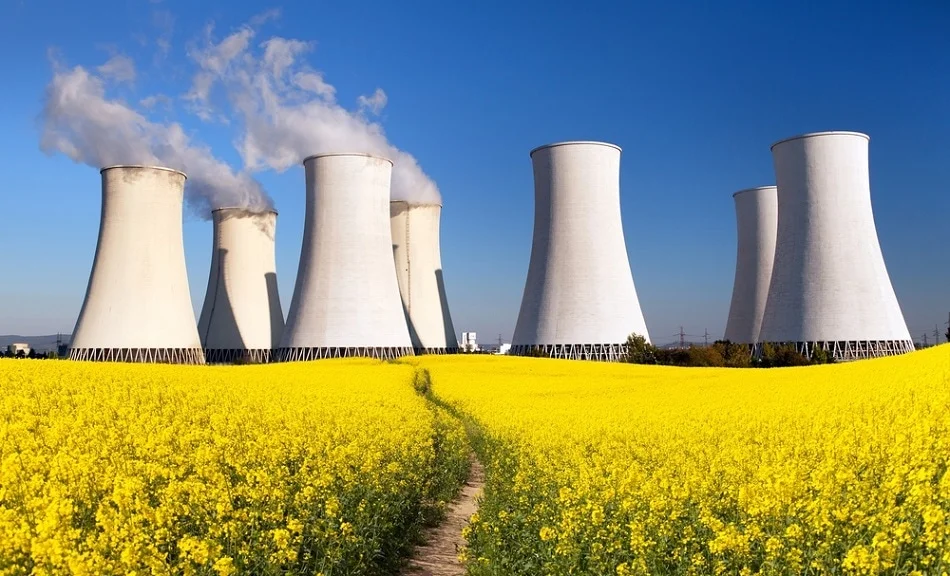

In [1]:
from IPython.display import Image
print('Nuclear power plants. Source: Daniel Prudek / Shutterstock).')
Image('image_powerplant.png')

Managing the supply and demand of electricity can be a complex and challenging task. Suppose that we are in charge of generating power for the U.S. State of Georgia. Assume that we know the set of all available power plants and the demand for power for each hour of a day. Can we create a schedule to decide how much power each plant should generate, and when to switch the plants "on" and "off"? How can we do so while minimizing the overall costs?

In this notebook, we model this decision-making problem using **mathematical optimization**. The first part of the notebook describes the datasets used. We use real data from the State of Georgia with a population of 10.8 million people. The data includes historical demand for power as well as specific information about the power plants.

The second part of the notebook introduces the three components of a mathematical optimization model: the objective function to be optimized, the decision variables, and the constraints. In our power generation problem, the **objective** is to minimize the overall costs. The **decision variables** model the power generation schedule. The **constraints** capture basic requirements such as ensuring that the power supply meets the demand, as well as practical limitations such as the minimum and maximum production levels for each power plant. By finding the optimally cost-efficient schedule, this model helps power plant operators get the best output from their facilities while minimizing the overall costs.


Let's get started.

## The data

First, let us load the following packages needed to process and visualize the data.

In [2]:
import pandas as pd   
import matplotlib.pyplot as plt  
import seaborn as sns  
import warnings
warnings.filterwarnings("ignore")

### Historical power demand data

First, read the demand data. 
The 'demand.csv' file contains the historical demand for power in the State of Georgia from 2004 to 2013. 
This data is available for each hour of the 31 days of two months --- summer month (July) and a winter month (January).

For the rest of this notebook, we will pick a date, say July 1st, 2011.

We store the demand as a dictionary indexed by each hour (between 1 and 24) and valued by the amount of power needed.

In [3]:
df_load_curves = pd.read_csv('demand.csv') 

# select the demand for the chosen day (July 1st, 2011)
df_subset = df_load_curves[(df_load_curves['YEAR']==2011)&(df_load_curves['MONTH']==7)&(df_load_curves['DAY']==1)] 

# store the demand to a dicionary
d = df_subset.set_index(['HOUR']).LOAD.to_dict() 

H = set(d.keys()) # set of hours in a day (1 through 24)

We can visualize the power usage in Georgia on July 1st, 2011.

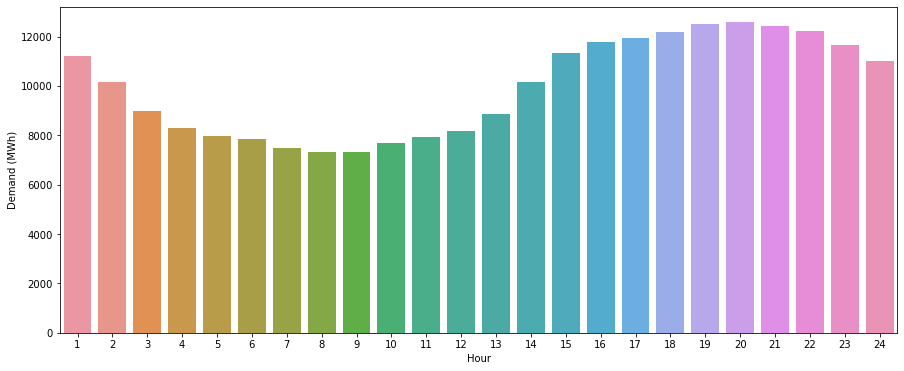

In [4]:
fig, ax = plt.subplots(figsize=(15,6)) 
demand_plot = sns.barplot(x=list(range(1,25)), y=[d[h] for h in range(1,25)])
demand_plot.set_xticklabels(demand_plot.get_xticklabels());
demand_plot.set(xlabel='Hour', ylabel='Demand (MWh)');
plt.show() 

The power utilization is higher in the evenings than in the mornings. 

### Power plant data

Next, let us load information about the power plants. 

The real dataset is **large**, with 99 power plants. Solving the optimization problem using the large dataset requires a full Gurobi license. 
If you are an academic (student or faculty), you can request a free Gurobi license [here](https://www.gurobi.com/academia/academic-program-and-licenses/).
To use the Gurobipy package without a license, this notebook uses a simplified smaller dataset with **ten groups** of power plants.
To test the model with the full data, simply replace 'small_plant_data' with 'large_plant_data' in the rest of the code.

Power plants come in different types based on the type of fuel they consume.
From our dataset, there are **six types** of power plants: coal, nuclear, oil, gas hydro, and biomass. 
In the small data used in this notebook, we have ten power plants - namely two nuclear plants (Edwin I Hatch and Vogtle) and three coal plants (Bowen, Jack McDonough and Scherer), with rest of the coal plants grouped into one mega-plant named 'OTHER COAL', and four groups of merged plants for each of the four plant types, named 'BIOMASS', 'GAS', 'HYDRO', and 'OIL'.

The **fuel** used by each power plant is also loaded from the files. This information is necessary to determine some of the fuel-dependent costs.

We now load this data.

In [5]:
df_plant_info = pd.read_csv('small_plant_data/plant_capacities.csv') # replace "small_plant_data" with "large_plant_data" to use the full dataset

P = set(df_plant_info['Plant'].unique())                          # set of all power plants

plant_type = df_plant_info.set_index('Plant').PlantType.to_dict() # plant type for each plant

P_N = set([i for i in P if plant_type[i]=='NUCLEAR'])             # set of all nuclear plants  

fuel_type = df_plant_info.set_index('Plant').FuelType.to_dict()   # fuel type for each plant


### Plant capacities and limits

The overall goal is to determine the amount of power to generate from each plant. This amount must be within the plant's minimum and maximum production limits (in MWh). See below for a visualization of the maximum production limits for the ten plants.

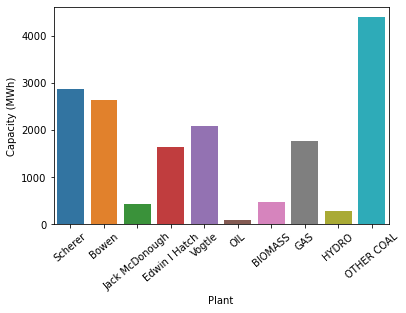

In [6]:
df_plant_info['capacity'] = df_plant_info['Capacity']
c = df_plant_info.set_index('Plant').capacity.to_dict() # generation capacity   

capacity_plot = sns.barplot(x=list(c.keys()), y=[c[k] for k in c])
capacity_plot.set_xticklabels(capacity_plot.get_xticklabels(), rotation=40);
capacity_plot.set(xlabel='Plant', ylabel='Capacity (MWh)');
plt.show() 

Clearly, coal plants are capable of the highest production capacities, followed by nuclear and hydro plants.

Moreover, if a nuclear power plant is turned "on," it has to generate at least 80% of its maximum capacity. For the rest of the plants, we set this minimum limit to 1%.

In [7]:
m = {i: 0.8 if i in P_N else 0.01 for i in P} # min % generation when on 

Additionally, we also have a limit on how much the power generation schedule can **ramp up** or **ramp down** the power generation between successive hours.
This limit ensures that the plants are not forced make drastic changes to their generation schedule.

We set this speed limit to be **20%** for nuclear plants and **25%** for coal plants. In other words, a coal plant cannot be ramped up or ramped down within an hour by more than 25% of its total capacity.
We set the speed limit to be **100%** for all other plants thereby imposing no limit on the speed.

In [8]:
r = {i: 1 if i in ['BIOMASS','GAS','HYDRO','OIL'] else .2 if i in P_N else .25 for i in P}  # ramp up/down speed (plant)  

### Costs

Finally, we load the cost data. There are five types of costs: fuel costs, operating costs, start-up and shut-down costs, and health costs.
We have historical yearly average data (for 2004-2011) on these costs based on fuel type.
For the rest of the notebook, we will use the average costs for 2011.

First is the **fuel costs**, which measure the cost of producing *one* MWh of power.
As visualized below, the coal and gas fuel types are the most expensive, while nuclear is the least expensive.

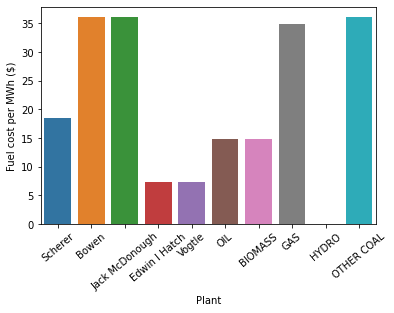

In [9]:
df_fuel_costs = pd.read_csv('small_plant_data/fuel_costs.csv') 

# read the fuel costs and transform it from fuel-type to plant-name
f = {i: df_fuel_costs[df_fuel_costs['year']==2011].T.to_dict()[9][fuel_type[i]] for i in fuel_type} # dictionary of fuel cost for each plant

# plot the fuel costs
fuelcost_plot = sns.barplot(x=list(f.keys()), y=[f[k] for k in f])
fuelcost_plot.set_xticklabels(fuelcost_plot.get_xticklabels(), rotation=40);
fuelcost_plot.set(xlabel='Plant', ylabel='Fuel cost per MWh ($)');
plt.show()

The second is the **operation costs**, which is the cost per hour of keeping a power plant on. 

In [10]:
df_oper_costs = pd.read_csv('small_plant_data/operating_costs.csv')  
o = {i: df_oper_costs[df_oper_costs['year']==2011].T.to_dict()[9][fuel_type[i]] for i in fuel_type} # operating cost/MWh (plant)

The third and fourth are the **startup** and **shutdown costs**, which penalize whenever a plant is started up and shut down. Incorporating these costs in the model ensures a stable power generation schedule.

In [11]:
df_startup_costs = pd.read_csv('small_plant_data/startup_costs.csv')  
s = {i: df_startup_costs[df_startup_costs['year']==2011].T.to_dict()[9][fuel_type[i]] for i in fuel_type} # operating cost/MWh (plant)
 
t = s.copy() # assume that the cost of shuting down = starting up

Finally, we load the **health costs**, which capture the health effects of burning too much coal. This data is only available for the three coal plants (Bowen, Jack McDonough and Scherer).


The health costs are aggregated using a variety of environmental factors that depend on the time of the day. As a result, these costs are indexed for each hour. See the visualization below for health costs for the Bowen power plant to observe that the costs are much higher in the evenings than in the mornings.

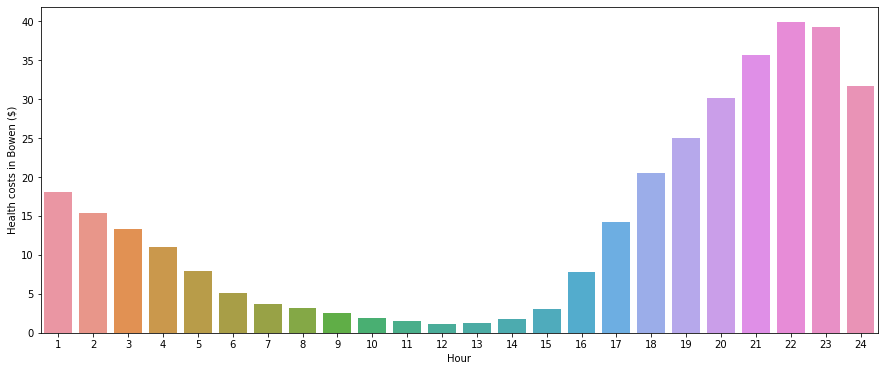

In [12]:
df_health_costs = pd.read_csv('small_plant_data/health_costs.csv')  
a = df_health_costs[(df_health_costs['Year']==2007)&(df_health_costs['Day']==1)].set_index(['Plant','Hour']).to_dict()['Cost'] # operating cost/MWh (plant)
a.update({(i,h): 0 for i in P for h in H if i not in ['Bowen','Jack McDonough','Scherer']})  

fig, ax = plt.subplots(figsize=(15,6)) 
healthcost_plot = sns.barplot(x=list(range(1,25)), y=[a['Bowen',h] for h in range(1,25)])
healthcost_plot.set_xticklabels(healthcost_plot.get_xticklabels());
healthcost_plot.set(xlabel='Hour', ylabel='Health costs in Bowen ($)');
plt.show() 

## Optimization model

We will now address the decision-making problem.
Using the ten power plants, and knowing their capabilities and limitations, what is the most cost-effective way to generate power from them in order to completely satisfy the energy demand in Georgia?

We can capture these complex considerations in a mathematical optimization model.
An optimization model finds the **best solution** according to an **objective function** such that the solution satisfies a set of **constraints**. 
Here, a solution is expressed as a vector of real values or integer values called **decision variables**.
Constraints are a set of equations or inequalities written as a function of the decision variables.

For our power generation problem, the objective is to minimize the overall costs.
The decision variables represent the power generation schedule for each power plant. 
The limits and capacities of the power plants are captured using the constraints.

Let us now define the inputs to the model. The subscripts $i$ and $h$ will be used to denote each power plant and hour, respectively.

### Input Parameters
Sets:
- $P\ (P_N)$: set of (nuclear) power plants,
- $H$: set of hours.

Demand, capacity and speed limits:
- $d_h$: power demand for each hour $h$,
- $c_i$: maximum power generation capacity for power plant $i$, 
- $m_i$: minimum % power that must be generated from power plant $i$, 
- $r_i$: ramp up/ramp down speed for power plant $i$.

Costs:
- $f_i, o_i$: fuel and operating costs for power plant $i$, 
- $a_{ih}$: health costs for power plant $i$ in hour $h$, 
- $s_i, t_i$: startup and shutdown costs for power plant $i$.

We have already loaded these parameters and have stored each input as a dictionary.

The following code loads the Gurobi python package and initiates the optimization model. 

In [13]:
import gurobipy as gp
from gurobipy import GRB
model = gp.Model("powergeneration")

Restricted license - for non-production use only - expires 2023-10-25


Having initiated the optimization model, we will now build the model step by step by adding the variables, objective and constraints.

First, we will define the decision variables.
There are several types of variables based on the range of values they can take.
A **continuous** variable can take any real value within lower and upper bounds, whereas a **binary** variable can be either 0 or 1.

Our key decision variable is a continuous variable.
Let $z_{i,h}$ be the amount of power to be generated from power plant $i$ during hour $h$; this has to be *at least* $0$.

We can add this variable to the model using gurobipy's **addVars** function.

In [14]:
z = model.addVars(P, H, name="z", lb=0)             # power generated in each plant for each hour 

The rest of the decision variables in our model are binary variables, meaning they act as on/off switches.
Let $u_{i,h}$ be an indicator of whether plant $i$ is *on* during hour $h$.
Further, let $v_{i,h}$ and $w_{i,h}$ be indicators of whether plant $i$ is *started up* or *shut down*, respectively, for hour $h$.
Each of these variables takes the value $1$ if true, or $0$ otherwise.

We now add these binary variables to the model using the **addVars** function.

In [15]:
u = model.addVars(P, H, name="u", vtype=GRB.BINARY) # is the plant on? for each plant and hour

v = model.addVars(P, H, name="v", vtype=GRB.BINARY) # start up the plant? for each plant and hour

w = model.addVars(P, H, name="w", vtype=GRB.BINARY) # shut down the plant? for each plant and hour 

print("This model has",len(z)+len(u)+len(v)+len(w),"decision variables.")

model.update()  

This model has 960 decision variables.


### Objective: Minimize the total costs 

Having defined the variables, we now tell the model what to optimize for.
We want to minimize the overall costs composed of five components - fuel, health, operating, startup and shutdown costs.
We can mathematically express the total cost using the decision variables as the following,

\begin{align*} 
\sum_{\textrm{plant}\ i} \sum_{\textrm{hour}\ h} (f_i z_{i,h} + a_{i,h} z_{i,h} + o_i u_{i,h} + s_i v_{i,h} + t_i w_{i,h})
\end{align*}

We now add this objective function to the model using the **setObjective** function.
The key input is the summation of all the terms.
Below is one way to add the five components one by one.

In [16]:
objective = gp.quicksum(f[i]*z[i,h] for i in P for h in H) # fuel cost
objective += gp.quicksum(a[i,h]*z[i,h] for i in P for h in H) # health cost
objective += gp.quicksum(o[i]*u[i,h] for i in P for h in H) # operating cost
objective += gp.quicksum(s[i]*v[i,h] for i in P for h in H) # startup cost
objective += gp.quicksum(t[i]*w[i,h] for i in P for h in H) # shutdown cost
model.setObjective(objective, sense=GRB.MINIMIZE)

Next, we tell the model what range of values the decision variables can take. This is done through *constraints*.

### Constraint: Meet demand 

First, we want to make sure that the total power generated by all the power plants in each hour is equal to the power demand in that hour.
This requirement can be mathematically expressed as the following equality constriant for each hour $h$.

\begin{align*} 
\sum_{\textrm{plant}\ i} z_{i,h} &= d_h
\end{align*}

We now add this constriant to our model using the **addConstrs** function.

In [17]:
model.addConstrs((gp.quicksum(z[i,h] for i in P) == d[h]) for h in H)  

model.update()

### Constraint:  Maximum and minimum generation levels

We make sure that the power generated from each plant does not exceed the plant's maximum capacity (denoted by $c_i$). This constraint can be expressed by the inequality $z_{i,h} \leq c_i$ for each plant and hour.
We also want to make sure that when the plant is "off", i.e. when $u_{i,h}=0$, we do not generate any power, i.e. $z_{i,h}=0$.
We can capture this by the following inequality for each plant $i$ and hour $h$,

\begin{align*} 
z_{i,h} \leq c_i u_{i,h}
\end{align*}

Furthermore, recall that each plant needs to generate a certain minimum % amount of power (denoted by $m_i$).
Nuclear power plants must produce at least 80% of their capacity and the rest of the plants must produce at least 1% of their capacity.
This can be expressed by the following inequality for each power plant $i$ and hour $h$,

\begin{align*} 
z_{i,h}  \geq m_i c_i u_{i,h}
\end{align*}

Note that this constraint also ensures that when there is no power generated, i.e., $z_{i,h} = 0$, then the plant is said to be turned "off", i.e., $u_{i,h} =0$.

We now add these constraints to the model.

In [18]:
model.addConstrs((z[i,h] <= c[i]*u[i,h]) for i in P for h in H)  

model.addConstrs((z[i,h] >= m[i]*c[i]*u[i,h]) for i in P for h in H)  

model.update()  

### Constraint:  Nuclear plants are always on 

Unlike the other types of power plants, nuclear power plants cannot be easily shut down within a short period of time.
In our model, we add a constriant that ensures that the nuclear power plants are always "on".
This can be done either by setting the $u$ variable to be $1$, or the following for each nuclear plant $i$ and hour $h$:

\begin{align*} 
 z_{i,h} \geq m_i c_i
\end{align*}

We now add these constraints to the model.

In [19]:
model.addConstrs((z[i,h] >= m[i]*c[i]) for i in P_N for h in H)   

model.update()

### Constraint:  Max rampdown, rampup 


While operating the power plants, it is preferable not to cause drastic changes in power generation.
We can enforce a limit on the speed at which power generation is ramped up or ramped down.
For each plant $i$, the quantity $z_{i,h} - z_{i,h-1}$ gives the difference in power generated between hours $h-1$ and $h$.


We can define constraints that ensure that the magnitude of  quantity is no more than a certain percentage of the maximum capacity.
This percentage is given by the ramp up/ramp down speed denoted by $r_i$.
These constraints can be mathematically expressed as the following for each plant $i$ and hour $h>1$,

\begin{align*} 
-r_i c_i   \leq z_{i,h} - z_{i,h-1} \leq r_i c_i
\end{align*}

We now add these constraints to the model.

In [20]:
model.addConstrs((z[i,h]-z[i,h-1] >= -r[i]*c[i]) for i in P for h in H if h>1)  

model.addConstrs((z[i,h]-z[i,h-1] <= r[i]*c[i]) for i in P for h in H if h>1)  

model.update()

### Constraint:  If switched on, must be on

Next, we ensure that when a power plant is switched "on," the plant is "on" (and in effect starts generating power).
Mathematically, when $v_{i,h}$ is $1$, $u_{i,h}$ is set to $1$.
Similarly, when a plant is "switched off," the plant is "off"; when $w_{i,h}$ is $1$, $u_{i,h}$ is set to $0$.

These constraints are linear inequalities expressed as the following for each plant $i$ and hour $h$,

\begin{align*} 
v_{i,h} \leq u_{i,h},\\
w_{i,h} \leq 1 - u_{i,h}
\end{align*}

We now add these constraints to the model.

In [21]:
model.addConstrs((v[i,h] <= u[i,h]) for i in P for h in H)  

model.addConstrs((w[i,h] <= 1-u[i,h]) for i in P for h in H)    

model.update()

### Constraint:  Link startup/shutdown variables to "on"/"off" variables

Finally, we link the startup/shutdown variables ($v$ and $w$) with the "on"/"off" variables ($u$).
Comparing two successive hours $h-1$ and $h$, the quantity $u_{i,h} - u_{i,h-1}$ can take one of three possible values: -1, 0, 1.
If it is -1, it means that the plant is "switched off" for hour $h$, forcing the variable $w_{i,h}$ to be $1$.
If it is 1, it means that the plant is "switched on" for hour $h$, forcing the variable $v_{i,h}$ to be $1$.
If it is 0, it means that the plant is neither "switched on" nor "switched off" for hour $h$; forcing the variables $w_{i,h}$ and $v_{i,h}$ to be $0$.

All of these possible combinations can be elegantly expressed using the following equality constraint for each plant $i$ and hour $h>1$,

\begin{align*} 
v_{i,h} - w_{i,h} = u_{i,h} - u_{i,h-1}
\end{align*}

We now add these constraints to the model.

In [22]:
model.addConstrs((v[i,h] - w[i,h] == u[i,h] - u[i,h-1]) for i in P for h in H if h > 1) 

model.update()

### Solve the model

Voila! We have completed building the model and we can solve the model using a call to **optimize()**.

In [23]:
model.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1722 rows, 960 columns and 4048 nonzeros
Model fingerprint: 0xe82b1f9b
Variable types: 240 continuous, 720 integer (720 binary)
Coefficient statistics:
  Matrix range     [8e-01, 4e+03]
  Objective range  [5e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 606 rows and 198 columns
Presolve time: 0.02s
Presolved: 1116 rows, 762 columns, 3206 nonzeros
Variable types: 216 continuous, 546 integer (546 binary)
Found heuristic solution: objective 5049245.7058

Root relaxation: objective 4.495120e+06, 197 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4495120.23    0   25 5049245.71 4495120.23  11.0%     -    0s
H    0     0   

We have solved the model!

### Optimal power schedule

We now visualize the power generation schedule. The following code retrieves the optimal values for the decision variables by simply adding .X to each variable. We then visualize the amount of power generated by each plant for 24 hours and compare it to the power demand curve.

Power supply:


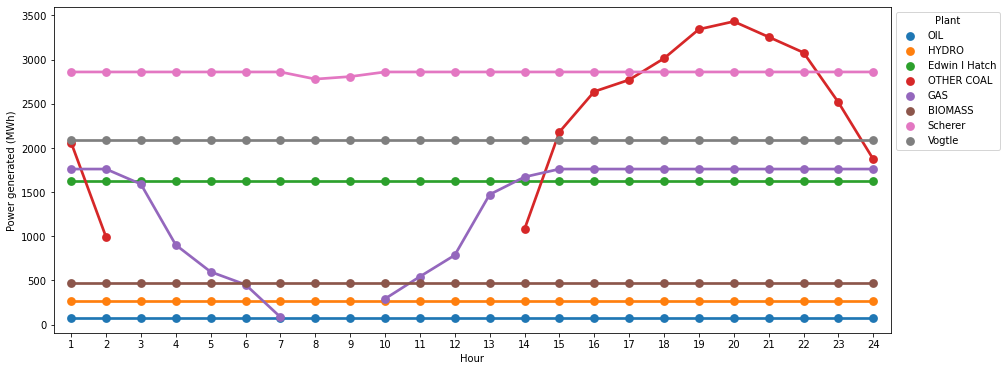

Power demand:


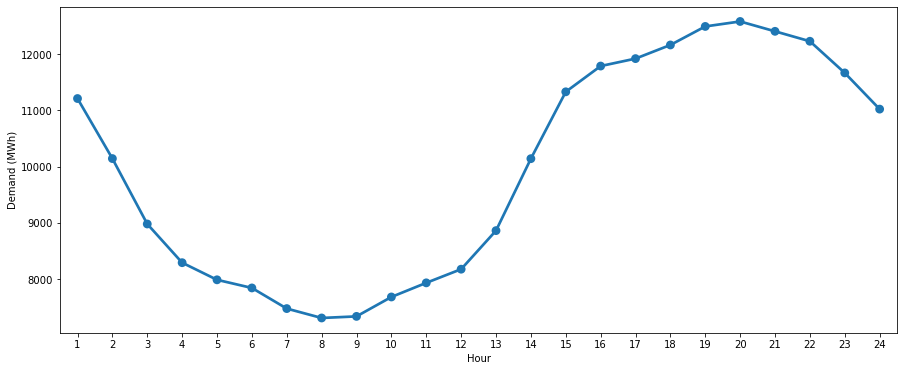

In [24]:
solution = pd.DataFrame() 
solution = pd.DataFrame(columns=['Hour', 'Power (MWh)', 'Plant']) 
plant_hour_pairs = [(h,i) for i in P for h in H  if z[i,h].X > 0] 
            
solution['Hour'] = [pair[0] for pair in plant_hour_pairs]
solution['Plant'] = [pair[1] for pair in plant_hour_pairs]
solution['Power generated (MWh)'] = [z[pair[1],pair[0]].X for pair in plant_hour_pairs]
            
print("Power supply:")
fig, ax = plt.subplots(figsize=(15,6)) 
sns.pointplot(data=solution,x='Hour', y='Power generated (MWh)', hue='Plant')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

print("Power demand:")
fig, ax = plt.subplots(figsize=(15,6)) 
demand = pd.DataFrame(columns=['Hour', 'Demand (MWh)']) 
demand['Hour'] = list(H)
demand['Demand (MWh)'] = [d[h] for h in H]
sns.pointplot(data=demand,x='Hour', y='Demand (MWh)')
plt.show() 


The optimally cost-effective power schedule draws the bulk of the power from the coal plant Scherer and nuclear plants Vogtle and Edwin I Hatch.

In order to match the fluctuation in power demand over the 24 hours, we see fluctuations in power generation in some plants.
The bulk of the fluctuations is carried by the "Other coal" plant; an especially extreme scenario is where it is turned off in hour 2 and restarted in hour 14.
We see a similar fluctuation in the Gas plant.

### Optimal costs

Below is a breakdown of the costs incurred by this optimal power schedule. As expected, the fuel costs and health costs are the major contributors to the overall cost. 

In [25]:
print("Fuel costs: $",round(sum(f[i]*z[i,h].X for i in P for h in H)*10**(-6),2),"million")
print("Health costs: $",round(sum(a[i,h]*z[i,h].X for i in P for h in H)*10**(-6),2),"million")
print("Operating costs: $",round(sum(o[i]*u[i,h].X for i in P for h in H),2))
print("Start-up costs: $",round(sum(s[i]*v[i,h].X for i in P for h in H),2))
print("Start-up costs: $",round(sum(s[i]*w[i,h].X for i in P for h in H),2))

Fuel costs: $ 4.29 million
Health costs: $ 0.2 million
Operating costs: $ 1622.73
Start-up costs: $ 219.0
Start-up costs: $ 219.0


###  Visualize the binary variables

We notice that the 'Other Coal' plant was switched "off" at one point and restarted at a later time. We can visualize how the switch "on" and "off" binary variables capture this scenario.

In [26]:
sol = pd.DataFrame()
plant = 'OTHER COAL'
sol['hour'] = [h for h in H]
sol['v[i,h]'] = [v[plant,h].X for h in H]
sol['w[i,h]'] = [w[plant,h].X for h in H]
sol['u[i,h]'] = [u[plant,h].X for h in H] 
sol['z[i,h]'] = [z[plant,h].X for h in H] 
sol

,hour,"v[i,h]","w[i,h]","u[i,h]","z[i,h]"
0,1,0.0,0.0,1.0,2060.91224
1,2,-0.0,-0.0,1.0,993.05342
2,3,-0.0,1.0,0.0,0.00000
3,4,-0.0,-0.0,0.0,0.00000
4,5,-0.0,-0.0,0.0,0.00000
5,6,-0.0,-0.0,0.0,0.00000
6,7,-0.0,-0.0,-0.0,0.00000
7,8,-0.0,-0.0,-0.0,0.00000
8,9,-0.0,-0.0,-0.0,0.00000
9,10,-0.0,-0.0,0.0,0.00000


## Full model

Below is the complete code to build and solve the optimization model.

In [27]:
import gurobipy as gp
from gurobipy import GRB
model = gp.Model("powergeneration")

# Define the variables
z = model.addVars(P,H,name="z", lb=0) # power generated in each plant for each hour 
u = model.addVars(P,H,name="u", vtype=GRB.BINARY, lb=0) # is the plant on? for each plant and hour
v = model.addVars(P,H,name="v", vtype=GRB.BINARY) # start up the plant? for each plant and hour
w = model.addVars(P,H,name="w", vtype=GRB.BINARY) # shut down the plant? for each plant and hour 

# Set the objective function by adding all the costs 
objective = gp.quicksum(f[i]*z[i,h] for i in P for h in H) # fuel cost
objective += gp.quicksum(a[i,h]*z[i,h] for i in P for h in H) # health cost
objective += gp.quicksum(o[i]*u[i,h] for i in P for h in H) # operating cost
objective += gp.quicksum(s[i]*v[i,h] for i in P for h in H) # startup cost
objective += gp.quicksum(t[i]*w[i,h] for i in P for h in H) # shutdown cost
model.setObjective(objective,sense=GRB.MINIMIZE)

# Set the constraint to meet the demand
model.addConstrs((gp.quicksum(z[i,h] for i in P) == d[h]) for h in H)  

# Set the constraint to set the minimum and maximum generation limits
model.addConstrs((z[i,h] >= m[i]*c[i]*u[i,h]) for i in P for h in H)  
model.addConstrs((z[i,h] <= c[i]*u[i,h]) for i in P for h in H)  

# Set the constraint to always keep the nuclear power plants on
model.addConstrs((z[i,h] >= m[i]*c[i]) for i in P_N for h in H)   

# Set the constraint to ensure that the ramp-up and ramp-down speeds are within limits
model.addConstrs((z[i,h]-z[i,h-1]  >= -r[i]*c[i]) for i in P for h in H if h>1)  
model.addConstrs((z[i,h]-z[i,h-1]  <= r[i]*c[i]) for i in P for h in H if h>1)  

# Set the constraint to ensure that if the plant is turned on, the plant should be on
model.addConstrs((v[i,h] <= u[i,h]) for i in P for h in H)  

# Set the constraint to ensure that if the plant is turned off, the plant should be off
model.addConstrs((w[i,h] <= 1-u[i,h]) for i in P for h in H)  

# Set the constraint to link the startup/shutdown variables (v,w) to the on/off variables (u)
model.addConstrs((v[i,h] - w[i,h] == u[i,h] - u[i,h-1]) for i in P for h in H if h > 1) 

# Solve the model
model.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1722 rows, 960 columns and 4048 nonzeros
Model fingerprint: 0x608e8d13
Variable types: 240 continuous, 720 integer (720 binary)
Coefficient statistics:
  Matrix range     [8e-01, 4e+03]
  Objective range  [5e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 606 rows and 198 columns
Presolve time: 0.03s
Presolved: 1116 rows, 762 columns, 3206 nonzeros
Variable types: 216 continuous, 546 integer (546 binary)
Found heuristic solution: objective 5049245.7058

Root relaxation: objective 4.495120e+06, 196 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4495120.23    0   25 5049245.71 4495120.23  11.0%     -    0s
H    0     0   